# Keypoints Detection Using MZModel

This example shows you how to use the dlpy.mzmodel subpackage to create a ResNet18 model to estimate keypoints in images. The dlpy.mzmodel subpackage leverages the SAS Deep Learning Model Zoo utilities to manage deep learning models on the CAS server.

The data is sourced from a WildTrack project in which SAS incorporated with WildTrack organization over footprint identification techinque(FIT). The image and keypoint data has been provided in a .sashdat file:
1. 676 color images with a single footprint in each image. The images have been cropped to be 224 x 224 pixels.
2. Each image uses 25 keypoints to describe the footprint. Each keypoint is specified by an (x,y) pair normalized in range of -1 to 1 with (0,0) denoting the center of the image.

## Set up environment

In [1]:
import swat as sw
from dlpy.mzmodel import *
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *

In [2]:
s = sw.CAS('your-server.unx.company.com',2999)

## Prepare the data

In [3]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/example/path',
                  subdirectories=True)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dnfs,PATH,,/example/path/,,1.0,1.0,0.0,0.0,0.0,0.0


In [5]:
s.table.loadTable(caslib='dnfs', path='wildtrack/wildtrack_species_landmarks.sashdat', 
    casout = dict(name = 'data', blocksize = '1', replace = True), where='nl_x24 ne .')

NOTE: Cloud Analytic Services made the file wildtrack/wildtrack_species_landmarks.sashdat available as table DATA in caslib dnfs.


[caslib]

 'dnfs'

[tableName]

 'DATA'

[casTable]

 CASTable('DATA', caslib='dnfs')

+ Elapsed: 1.18s, user: 0.306s, sys: 0.87s, mem: 76.9mb

In [6]:
targets = list(s.columninfo('data').ColumnInfo.Column.values[-50:])
targets.sort(key=lambda x: int(x[max(x.find('x'), x.find('y')) + 1:]))
dataset = ImageTable.from_table(label_col='species', tbl=s.CASTable('data'), columns=targets)

In [7]:
dataset.resize(224, columns=targets)
trainset, testset = two_way_split(tbl=dataset, test_rate=10, im_table=False, stratify=False)

## Model construction

Create a ResNet18 model by using the `MZModel()` constructor. Because ResNet18 is available in the Deep Learning Model Zoo, you can specify the architecture by using `type="torchNative"`, `name="resnet"` and `subtype="resnet18"`. Fit the model to the data set by specifying `dataset_type="regression"` and `num_classes=50` to account for the 50 keypoints in the data set. If you have a set of weights for the architecture, you can begin training from that set of weights by setting the `model_path` to the path of the file that contains the weights.

In [8]:
model = MZModel(conn=s, model_type = "torchNative", model_name="resnet", model_subtype="resnet18", 
                dataset_type="regression", num_classes=50, model_path = "/path/to/resnet18.pt")

For regression models, we choose `loss_func="mse"` as the loss function.

In [9]:
optimizer=Optimizer(seed=54321, 
                    algorithm=SGDSolver(lr=0.001, momentum=0.9),
                    batch_size=20,
                    loss_func="mse",
                    max_epochs=15                   
                    )

## Train the model

In [10]:
model.train(table=trainset, inputs="_image_", targets=targets, gpu=[0], optimizer=optimizer)

NOTE: No target map from nominal values to numeric values is found.
NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: dlx executable command : /opt/vbviya/laxno/20230517/TKGrid/bin/dlxexe -controlpid 66863 -session 6
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 20 records at a time.
NOTE: Starting dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 727585 device= GPU:0
NOTE: Learning Rate:   0.001 Momentum:     0.9 Weight Decay:       0 Dampening:       0 BatchSize: 20 Rank: 0 Device: 0 Loss: 7.75938
NOTE: The action completed successfully.


,Epoch,Loss,MSE
0,0.0,260.630890,13.106112
1,1.0,30.997389,1.566854
2,2.0,18.676465,0.941275
3,3.0,16.158574,0.813131
4,4.0,14.532558,0.730487
5,5.0,13.292601,0.667647
6,6.0,12.284113,0.616629
7,7.0,11.432079,0.573583
8,8.0,10.704498,0.536859
9,9.0,10.069493,0.504837


## Score the model

In [11]:
model.score(table=testset, inputs="_image_", targets=targets, gpu=[0], batch_size=128, loss_func="mse")

NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: No target map from nominal values to numeric values is found.
NOTE: In the score output, expected nominal values will be in raw numeric representation.
NOTE: dlx executable command : /opt/vbviya/laxno/20230517/TKGrid/bin/dlxexe -controlpid 66863 -session 6
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 128 records at a time.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 727585 device= GPU:0
NOTE: The action completed successfully.


,Loss,MSE
0,2.208466,0.033976


## Visualize predicted values

In [12]:
output_targets=list(s.columninfo(model.table_out).ColumnInfo.Column.values[-50:])

In [13]:
def plot_landmarks(conn, targets, image_list=range(4), n_col=2, figsize=None):
    import cv2
    n_images = len(image_list)
    num_obs = conn.numrows(model.table_out)['numrows']
    res_img = conn.fetchimages(table=model.table_out, to=num_obs).Images
    res_label = conn.fetch(model.table_out, fetchvars=targets, to=num_obs).Fetch

    if n_images > n_col:
        n_row = n_images // n_col + 1
    else:
        n_row = 1
        n_col = n_images

    if figsize is None:
        figsize = (16, 16 // n_col * n_row)

    fig = plt.figure(figsize=figsize)

    idx_img = 1
    for i in image_list:
        img = res_img.loc[i, 'Image']
        img_arr = np.array(img)
        circle_size = int(min(img_arr.shape[:2])/40)
        for k in range(0, len(targets), 2):
            x = int(res_label.loc[i, targets[k]] * res_img.loc[i, 'Width'] / 2 + res_img.loc[i, 'Width'] / 2)
            y = int(res_label.loc[i, targets[k + 1]] * res_img.loc[i, 'Height'] / 2 + res_img.loc[i, 'Height'] / 2)
            cv2.circle(img_arr, (x, y), circle_size, (255, 0, 0), -1)
        ax = fig.add_subplot(n_row, n_col, idx_img)
        plt.imshow(img_arr, cmap='gray')
        idx_img = idx_img + 1
        plt.xticks([]), plt.yticks([])
    plt.show()

NOTE: The table TABLE_JTKX3M contains encoded images.


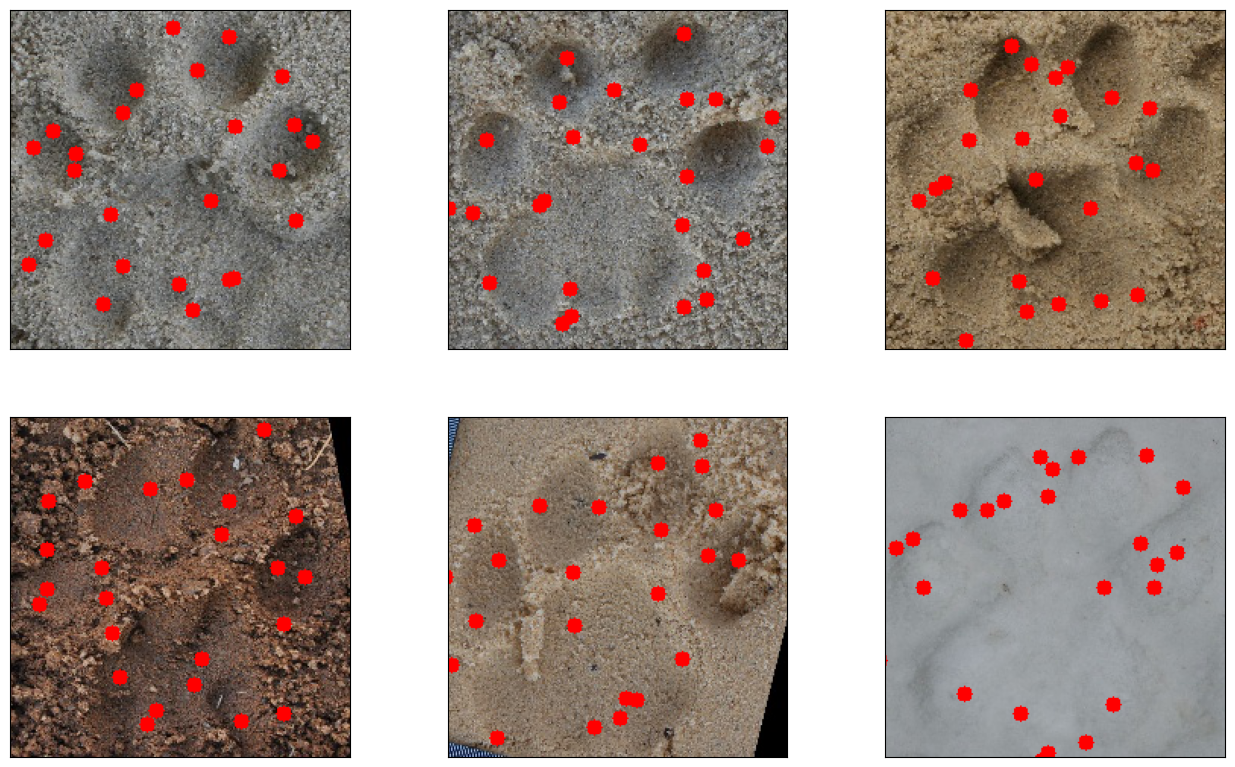

In [14]:
plot_landmarks(s, targets=output_targets, image_list=range(6), n_col=3)